In [1]:
import numpy as np
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm,binom
from scipy.io import loadmat
from scipy.special import digamma, gammaln, gamma
from numpy.linalg import inv
#import cv2
from scipy import ndimage
import tensorflow as tf

In [2]:
from keras.layers import Conv2D, BatchNormalization, Activation
from keras.models import Model, Input
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [3]:
from utils.data_load import Image_data

In [4]:
image_data = Image_data(npyfilename = 'PASCAL_data.npy',
                        kernel_file_name = 'kernel1.mat')

original images loaded


In [5]:
image_data.compute_image_conv()

conv images created


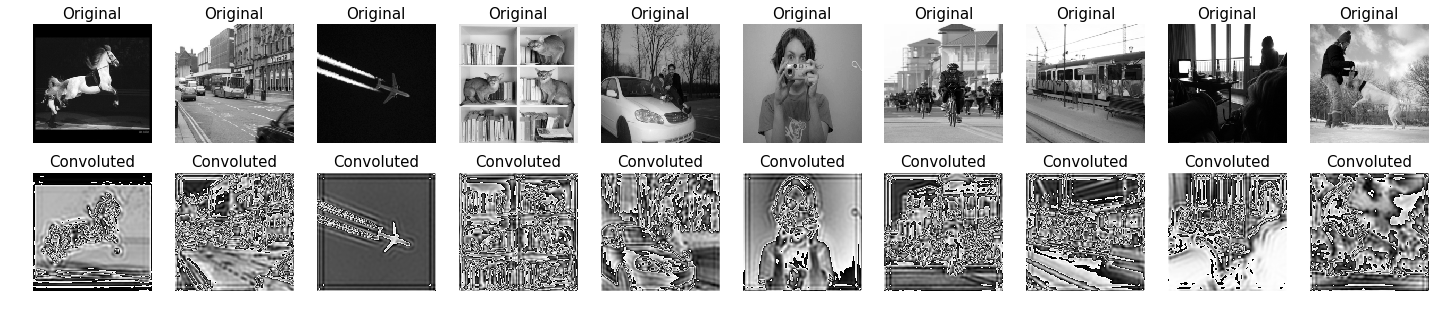

In [6]:
f, ax = plt.subplots(2,10,figsize=(25,5))
for i in range(10):
    ax[0,i].imshow((image_data.original_images[i,:,:]).astype('uint8'),cmap='gray');  ax[0,i].axis('Off'); ax[0,i].set_title('Original', size=15)
    ax[1,i].imshow((image_data.conv_images[i,:,:]).astype('uint8'),cmap='gray');  ax[1,i].axis('Off'); ax[1,i].set_title('Convoluted', size=15)
plt.show()

In [7]:
image_data.normalise()

In [8]:
orig,conv = image_data.load_data()

In [9]:
conv.shape

(27088, 224, 224)

In [10]:
np.random.seed(100)
mask = np.arange(image_data.total_image_num)
np.random.shuffle(mask)
num_validation = int(image_data.total_image_num/25)
num_training = image_data.total_image_num - num_validation
orig = orig[mask]
conv = conv[mask]

X_train, Y_train = conv[:num_training], orig[:num_training]
X_val, Y_val = conv[num_training:], orig[num_training:]

print('Xtrain shape: ',X_train.shape)
print('Ytrain shape: ',Y_train.shape)
print('Xval shape: ',X_val.shape)
print('Yval shape: ',Y_val.shape)



Xtrain shape:  (26005, 224, 224)
Ytrain shape:  (26005, 224, 224)
Xval shape:  (1083, 224, 224)
Yval shape:  (1083, 224, 224)


In [11]:
X_train = X_train.reshape((26005,224,224,1))
Y_train = Y_train.reshape((26005,224,224,1))
X_val = X_val.reshape((1083,224,224,1))
Y_val = Y_val.reshape((1083,224,224,1))

In [12]:
Y_train.shape

(26005, 224, 224, 1)

In [13]:
mask

array([ 9218, 15566,  8207, ..., 14147, 23320,  5640])

In [14]:
deblur_CNN_input = Input(shape=(224,224,1))

#HIDDEN LAYERS
deblur_CNN_layer1 = Conv2D(filters=16, kernel_size=7, strides = 1, padding='same')(deblur_CNN_input)
deblur_CNN_layer1 = BatchNormalization()(deblur_CNN_layer1)
deblur_CNN_layer1 = Activation('relu')(deblur_CNN_layer1)

deblur_CNN_layer2 = Conv2D(filters=16, kernel_size=5, strides = 1, padding='same')(deblur_CNN_layer1)
deblur_CNN_layer2 = BatchNormalization()(deblur_CNN_layer2)
deblur_CNN_layer2 = Activation('relu')(deblur_CNN_layer2)

deblur_CNN_layer3 = Conv2D(filters=16, kernel_size=5, strides = 1, padding='same')(deblur_CNN_layer2)
deblur_CNN_layer3 = BatchNormalization()(deblur_CNN_layer3)
deblur_CNN_layer3 = Activation('relu')(deblur_CNN_layer3)

deblur_CNN_output = Conv2D(filters=1, kernel_size=3, strides = 1, padding='same', activation='relu')(deblur_CNN_layer3)

deblur_CNN = Model(inputs= deblur_CNN_input, outputs=deblur_CNN_output )

In [15]:
deblur_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 16)      6416      
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 16)      0         
__________

In [16]:
adam = Adam(lr= 0.001)
deblur_CNN.compile(optimizer= adam, loss= 'mean_absolute_error')

In [17]:
deblur_CNN.fit(X_train, Y_train,batch_size = 256, epochs=5,validation_data=(X_val,Y_val))

Train on 26005 samples, validate on 1083 samples
Epoch 1/5
26005/26005 [==============================] - 218s 8ms/step - loss: 0.0143 - val_loss: 0.0068
Epoch 2/5
26005/26005 [==============================] - 197s 8ms/step - loss: 0.0076 - val_loss: 0.0068
Epoch 3/5
26005/26005 [==============================] - 197s 8ms/step - loss: 0.0076 - val_loss: 0.0068
Epoch 4/5
 9472/26005 [=========>....................] - ETA: 2:03 - loss: 0.0078

KeyboardInterrupt: 

In [ ]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

In [19]:
y_pred = deblur_CNN.predict(Y_val[0:3])

In [23]:
y_pred.shape

(3, 224, 224, 1)

In [27]:
y_pred

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 